<a href="https://colab.research.google.com/github/BangachevKiril/RepresentationLearningTheory/blob/main/SigLIPModalityGapImageNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Description

This code provides experiments for the modality gap in SigLIP following the [paper by Kiril Bangachev, Guy Bresler, Iliyas Noman, Yury Polyansnkiy](??)

The code is adpted from a [Notebook on SigLIP2 Experiments by Google DeepMind](https://colab.research.google.com/github/google-research/big_vision/blob/main/big_vision/configs/proj/image_text/SigLIP_demo.ipynb)

As the experiment does not require a massive amount of data, we choose to work with a subset of the ImageNET dataset. Specifically, we work with the [ILSVRC2012 validation dataset](https://image-net.org/challenges/LSVRC/2012/2012-downloads.php) which has 50 000 labelled images.

In [ ]:
#@markdown # Environment setup
#@markdown **IMPORTANT NOTE**: Modern jax (>0.4) does not support the Colab TPU
#@markdown anymore, so don't select TPU runtime here. CPU and GPU work and are both fast enough.

# Install the right jax version for TPU/GPU/CPU
import os
if 'COLAB_TPU_ADDR' in os.environ:
  raise "TPU colab not supported."
elif 'NVIDIA_PRODUCT_NAME' in os.environ:
  !nvidia-smi
import jax
jax.devices()


# Get latest version of big_vision codebase.
!git clone --quiet --branch=main --depth=1 https://github.com/google-research/big_vision
!cd big_vision && git pull --rebase --quiet
!pip -q install -r big_vision/big_vision/requirements.txt
# Gives us ~2x faster gsutil cp to get the model checkpoints.
!pip3 -q install --no-cache-dir -U crcmod

%cd big_vision


import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import jax
import jax.numpy as jnp
import ml_collections

from google.colab.output import _publish as publish

Mon May 12 21:10:14 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Choose and load model, perform inference

In [ ]:
# Pick your hero: (WHEN CHANGING THIS, RERUN IMAGE/TEXT EMBEDDING CELLS)
# Give this cell 1-3mins.

# VARIANT, RES = 'B/16', 224
# VARIANT, RES = 'B/16', 256
VARIANT, RES = 'B/16', 384
# VARIANT, RES = 'B/16', 512
# VARIANT, RES = 'L/16', 256
# VARIANT, RES = 'L/16', 384
# VARIANT, RES = 'So400m/14', 224
# VARIANT, RES = 'So400m/14', 384
# VARIANT, RES = 'B/16-i18n', 256
# VARIANT, RES = 'So400m/16-i18n', 256

CKPT, TXTVARIANT, EMBDIM, SEQLEN, VOCAB = {
    ('B/16', 224): ('webli_en_b16_224_63724782.npz', 'B', 768, 64, 32_000),
    ('B/16', 256): ('webli_en_b16_256_60500360.npz', 'B', 768, 64, 32_000),
    ('B/16', 384): ('webli_en_b16_384_68578854.npz', 'B', 768, 64, 32_000),
    ('B/16', 512): ('webli_en_b16_512_68580893.npz', 'B', 768, 64, 32_000),
    ('L/16', 256): ('webli_en_l16_256_60552751.npz', 'L', 1024, 64, 32_000),
    ('L/16', 384): ('webli_en_l16_384_63634585.npz', 'L', 1024, 64, 32_000),
    ('So400m/14', 224): ('webli_en_so400m_224_57633886.npz', 'So400m', 1152, 16, 32_000),
    ('So400m/14', 384): ('webli_en_so400m_384_58765454.npz', 'So400m', 1152, 64, 32_000),
    ('B/16-i18n', 256): ('webli_i18n_b16_256_66117334.npz', 'B', 768, 64, 250_000),
    ('So400m/16-i18n', 256): ('webli_i18n_so400m_16_256_78061115.npz', 'So400m', None, 64, 250_000),
}[VARIANT, RES]

# It is significantly faster to first copy the checkpoint (30s vs 8m30 for B and 1m vs ??? for L)
!test -f /tmp/{CKPT} || gsutil cp gs://big_vision/siglip/{CKPT} /tmp/

if VARIANT.endswith('-i18n'):
  VARIANT = VARIANT[:-len('-i18n')]

import big_vision.models.proj.image_text.two_towers as model_mod

model_cfg = ml_collections.ConfigDict()
model_cfg.image_model = 'vit'  # TODO(lbeyer): remove later, default
model_cfg.text_model = 'proj.image_text.text_transformer'  # TODO(lbeyer): remove later, default
model_cfg.image = dict(variant=VARIANT, pool_type='map')
model_cfg.text = dict(variant=TXTVARIANT, vocab_size=VOCAB)
model_cfg.out_dim = (None, EMBDIM)  # (image_out_dim, text_out_dim)
model_cfg.bias_init = -10.0
model_cfg.temperature_init = 10.0

model = model_mod.Model(**model_cfg)

# Using `init_params` is slower but will lead to `load` below performing sanity-checks.
# init_params = jax.jit(model.init, backend="cpu")(jax.random.PRNGKey(42), jnp.zeros([1, RES, RES, 3], jnp.float32), jnp.zeros([1, SEQLEN], jnp.int32))['params']
init_params = None  # Faster but bypasses loading sanity-checks.

params = model_mod.load(init_params, f'/tmp/{CKPT}', model_cfg)

Copying gs://big_vision/siglip/webli_en_b16_384_68578854.npz...
/ [1 files][721.4 MiB/721.4 MiB]                                                
Operation completed over 1 objects/721.4 MiB.                                    


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Embed Images

In [ ]:
from PIL import Image
import os
import numpy as np
import big_vision.pp.builder as pp_builder
import big_vision.pp.ops_general
import big_vision.pp.ops_image
import big_vision.pp.ops_text
import time as time

## Preprocessing

In [ ]:
K = 50000
d = EMBDIM
data_path = '/content/drive/My Drive/imagenetdata/ImageNetValidation/Images/ILSVRC2012_img_val/'
image_names = os.listdir(data_path)

In [ ]:
imageidx = []
start = time.time()
i = 0
for file in image_names:
  namedata = file.split("_")[-1]
  index = namedata.split(".")[0]
  imageidx.append(int(index)-1)
  i+= 1

## Embedding

In [ ]:
pp_img = pp_builder.get_preprocess_fn(f'resize({RES})|value_range(-1, 1)')
d = EMBDIM
embeddings_images = np.zeros((10000, d))
i = 0
batch = 1
start = time.time()
for file in image_names:
  if i<10000*batch:
    continue
  if i >= 10000*(batch+1):
    break
  if i % 100== 0:
    print(i, (time.time()-start)/60)
    np.savez(f"/content/drive/My Drive/imagenetdata/ImageNetValidation/image_representations_{batch}.npz",embeddings_images)
  image = Image.open(os.path.join(data_path, file))
  image = image.resize((RES, RES))
  npimage = np.array(image)
  if npimage.shape != (RES, RES, 3):
    npimage = image = image.convert('RGB')
    npimage = np.array(image)
  image = pp_img({'image': npimage})['image']
  image = np.expand_dims(image, axis=0)
  zimg,zt,out = model.apply({'params': params}, image, None)
  embeddings_images[i -10000*batch , :] = zimg.reshape(zimg.shape[-1])
  i += 1

0 5.1299730936686196e-06
AttributeError: module 'ml_dtypes' has no attribute 'float4_e2m1fn'
100 2.6977450450261435
200 4.78897697130839
300 6.901686986287435
400 9.166135076681773
500 11.424491620063781
600 13.671237115065257
700 15.954310365517934
800 18.183310675621033
900 20.39344773689906
1000 22.67398887872696
1100 24.981606471538544
1200 27.315183707078297
1300 29.554183673858642
1400 31.78936828772227
1500 33.971040459473926
1600 36.136438409487404
1700 38.32463649113973
1800 40.56392310063044
1900 42.80484730402629
2000 44.979073715209964
2100 47.2771422068278
2200 49.573679983615875
2300 51.77052263418833
2400 54.00066756804784
2500 56.23959940671921
2600 58.436008059978484
2700 60.69955035448074
2800 62.95425842205683
2900 65.13187619050343
3000 67.32981855074564
3100 69.5100424528122
3200 71.7048013885816
3300 73.91877919832865
3400 76.18040478229523
3500 78.39017380873362
3600 80.64182344675064
3700 82.9020919640859
3800 85.17092314958572
3900 87.46548819541931
4000 89.671

# Embed Text

## Preprocessing

In [ ]:
labels_numberred = np.loadtxt( '/content/drive/My Drive/imagenetdata/ImageNetValidation/Labels.txt')
labels_numberred = labels_numberred.astype(int)

file_path = '/content/drive/My Drive/imagenetdata/ImageNetValidation/map_clsloc.txt'

with open(file_path, 'r') as file:
  map = file.readlines()
map = [line.strip() for line in map]
map = [x.split(" ") for x in map]
map = {int(line[1]):line[2] for line in map}
labels = [map[ell] for ell in labels_numberred]
labels = [word.replace("_", " ") for word in labels]
labels = [labels[i] for i in imageidx]

## Embedding

In [ ]:
TOKENIZERS = {
    32_000: 'c4_en',
    250_000: 'mc4',
}
K = 50000
d= EMBDIM
pp_txt = pp_builder.get_preprocess_fn(f'tokenize(max_len={SEQLEN}, model="{TOKENIZERS[VOCAB]}", eos="sticky", pad_value=1, inkey="text")')
embeddings_text = np.zeros((K, d))
start = time.time()
embedded_so_far = dict()
for i in range(K):
  if i % 100 == 0:
    print(i, (time.time()-start)/60)
    # np.savez("/content/drive/My Drive/imagenetdata/ImageNetValidation/text_representations.npz",embeddings_text)
  if labels[i] in embedded_so_far.keys():
    embeddings_text[i, :] = embedded_so_far[labels[i]]
    continue
  # print(labels[i])
  else:
    token = np.array(pp_txt({'text': labels[i]})['labels']).reshape(1, -1)
    zi, ztext,out = model.apply({'params': params}, None, token)
    embedded_so_far[labels[i]] = ztext.reshape(ztext.shape[-1])
    embeddings_text[i, :] = ztext.reshape(ztext.shape[-1])

0 4.38690185546875e-06
100 0.1513478914896647
200 0.16469000975290934
300 0.18167883555094402
400 0.19502294460932415
500 0.30805301666259766
600 0.32072655359903973
700 0.3598366578420003
800 0.3725040078163147
900 0.38803433179855346
1000 0.41202342907587686
1100 0.46374283234278363
1200 0.5253810286521912
1300 0.5380778352419535
1400 0.592343827088674
1500 0.6060718933741251
1600 0.6493552287419637
1700 0.6627138217290243
1800 0.6769726196924846
1900 0.6917530576388041
2000 0.7151712695757548
2100 0.8687414407730103
2200 0.9091381311416626
2300 0.960967195034027
2400 1.013232171535492
2500 1.0264405568440755
2600 1.0679380734761557
2700 1.1303664644559224
2800 1.1436792731285095
2900 1.1574976007143656
3000 1.1708021720250448
3100 1.351888887087504
3200 1.3647327820460002
3300 1.3793489575386046
3400 1.3943402489026389
3500 1.4086431701978048
3600 1.4227608521779378
3700 1.4369617184003194
3800 1.4510402003924052
3900 1.4652034640312195
4000 1.479563864072164
4100 1.7858785072962442

# Load

In [ ]:
K, d = 50000, EMBDIM
embeddings_text = np.load("/content/drive/My Drive/imagenetdata/ImageNetValidation/text_representations.npz")['arr_0']
embeddings_images = np.zeros((K, d))
for b in range(2):
  images = np.load(f"/content/drive/My Drive/imagenetdata/ImageNetValidation/image_representations_{b}.npz")['arr_0']
  embeddings_images[b*10000: (b+1)*10000, :] = images[b*10000: (b+1)*10000, :]

# Check Retrieval

In [ ]:
K = 20000
unique_labels = np.unique(labels[:K])
unique_labels_idx = [int(np.argmax(np.array(labels) ==u)) for u in unique_labels]
unique_labels_idx = np.array(unique_labels_idx).astype(int)
print(len(unique_labels_idx))

401


In [ ]:
images = np.load(f"/content/drive/My Drive/imagenetdata/ImageNetValidation/image_representations_{0}.npz")['arr_0']
np.savez(f"/content/drive/My Drive/imagenetdata/ImageNetValidation/image_representations_0.npz", images[:10000, :])

In [ ]:
images = np.load(f"/content/drive/My Drive/imagenetdata/ImageNetValidation/image_representations_{1}.npz")['arr_0']
images[9999,:]

array([ 1.31594697e-02,  3.82068381e-03,  5.95876798e-02, -7.69881671e-03,
       -1.71858668e-02,  2.05163471e-02, -5.45031903e-03,  3.41128442e-03,
       -3.24011408e-02, -2.80975997e-02, -5.12927910e-03,  1.83473136e-02,
        2.69545857e-02, -7.58012384e-03,  3.66148166e-02,  1.19631207e-02,
        3.39350924e-02, -4.19336595e-02,  1.94168892e-02,  1.83798168e-02,
       -6.11781934e-03,  7.99627136e-03, -3.69671509e-02,  8.45918246e-03,
       -2.04157140e-02, -7.57911522e-03, -4.45006322e-03, -4.97931167e-02,
       -6.41739462e-03,  9.62569751e-03,  1.33025357e-02, -2.31584813e-02,
       -8.11098889e-03, -6.45267172e-03,  1.63025912e-02,  1.08858915e-02,
        1.48123559e-02,  1.35625480e-02,  2.00786665e-02, -2.25375295e-02,
        4.06500772e-02,  9.07600392e-03, -3.44611146e-03,  1.34916883e-02,
        1.19225439e-02, -1.49991224e-02, -3.81876118e-02,  1.14233894e-02,
       -3.68208834e-03, -1.22040743e-02,  7.09413085e-03, -9.52625196e-05,
        2.38300543e-02,  

In [ ]:
first_images = embeddings_images[unique_labels_idx,:]
first_text = embeddings_text[unique_labels_idx,:]
comp = first_images @ first_text.T
comp[:5,:5]

array([[ 0.1062845 , -0.02236889, -0.02699761, -0.05692268, -0.0555437 ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

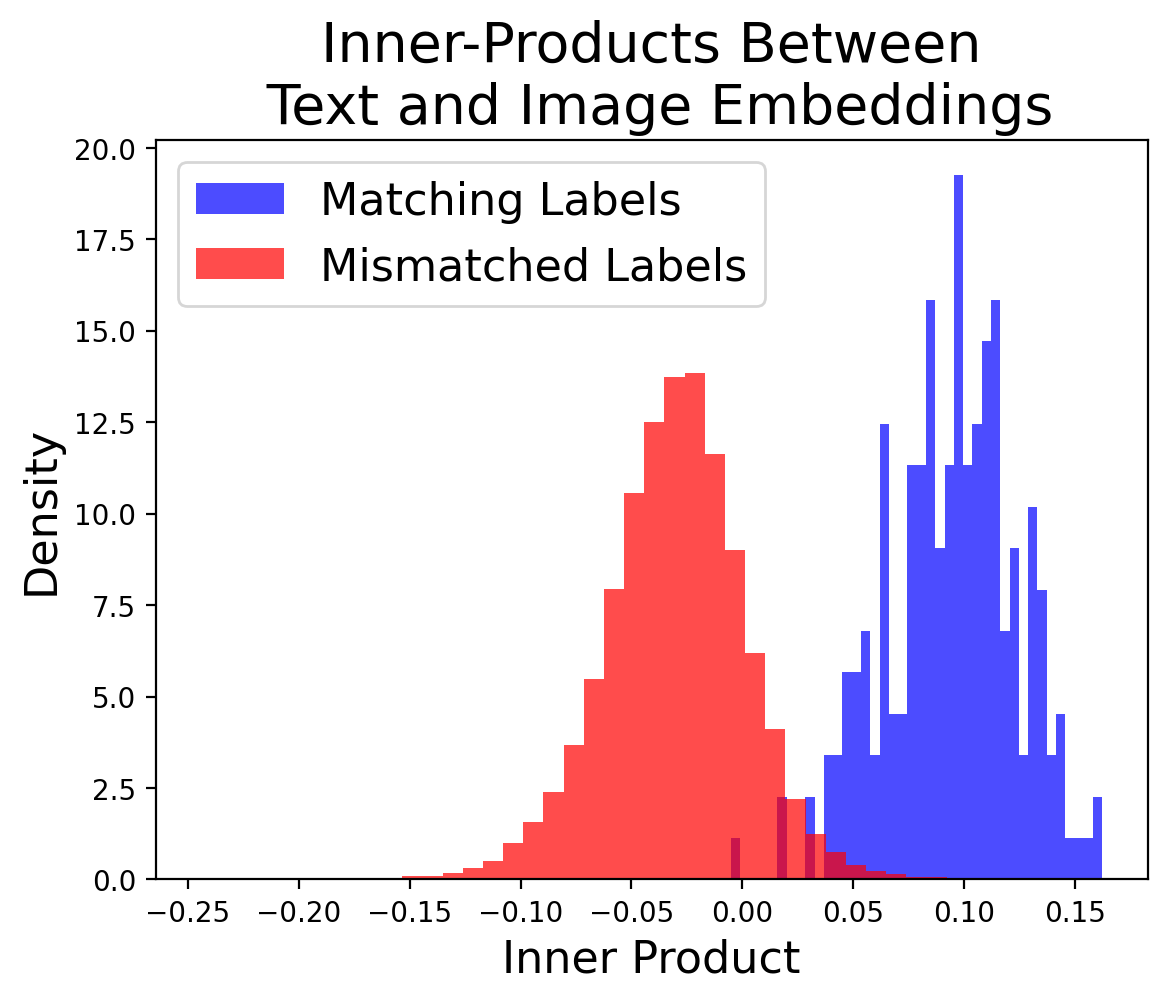

In [ ]:
diagonal_elements = np.diag(comp)
off_diagonal_elements = comp[~np.eye(comp.shape[0], dtype=bool)]

# Create the density histogram
plt.hist(diagonal_elements, bins=40, color='blue', alpha=0.7, label='Matching Labels', density=True)
plt.hist(off_diagonal_elements, bins=40, color='red', alpha=0.7, label='Mismatched Labels', density=True)

# Customize the plot
plt.title('Inner-Products Between\n Text and Image Embeddings', fontsize = 20)
plt.xlabel('Inner Product', fontsize = 16)
plt.ylabel('Density', fontsize = 16)
plt.legend(fontsize = 16)

# Show the plot
plt.show()

# Check Modality Gap

In [ ]:
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split

In [ ]:
K = 10000
representations = np.concatenate([embeddings_images[:K,:], embeddings_text[:K,:]])
modality = np.concatenate([-np.ones(K), np.ones(K)])

train_representations, test_representation, train_modality, test_modality = train_test_split(
    representations, modality, test_size=0.2, random_state=42)
classifier = Perceptron(fit_intercept=True)
classifier.fit(train_representations,train_modality)

Perceptron()

In [ ]:
prediction = classifier.predict(test_representation)
np.sum(prediction == test_modality)/len(test_modality)

np.float64(1.0)

In [ ]:
predicted = np.matmul(test_representation, classifier.coef_.reshape(classifier.coef_.shape[-1])) + classifier.intercept_
predicted_text = predicted[test_modality == 1]
predicted_image = predicted[test_modality == -1]

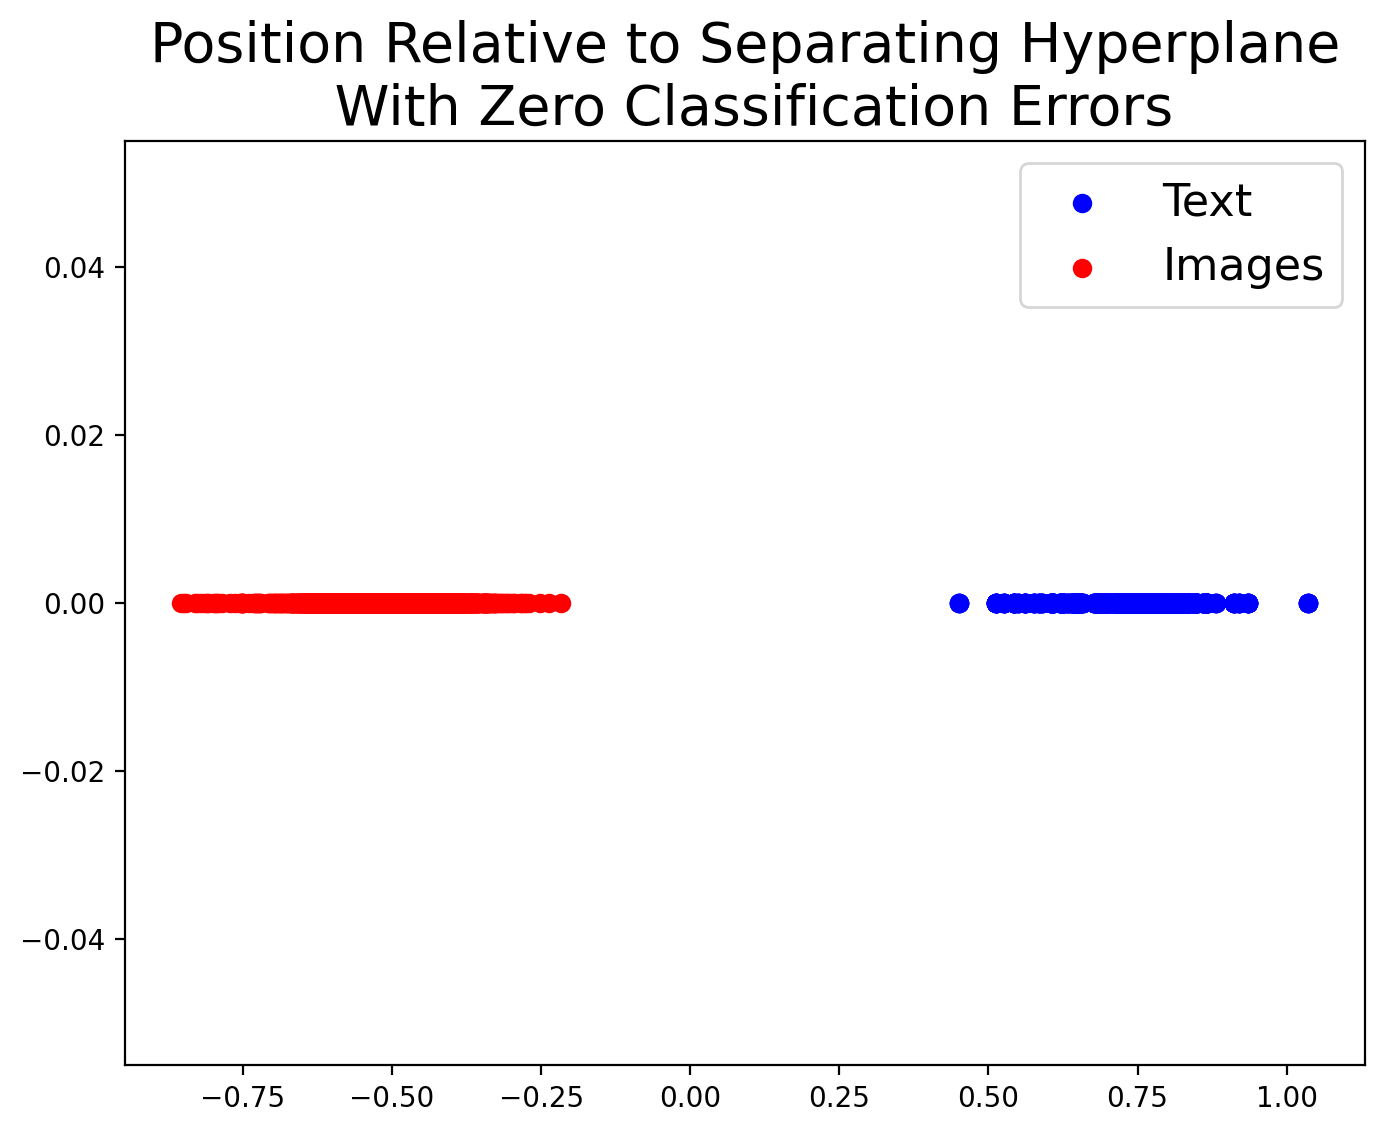

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))  # Adjust figure size if needed

# Plot class 1 data in blue
plt.scatter(predicted_text, np.zeros_like(predicted_text), color='blue', label='Text')

# Plot class 2 data in red
plt.scatter(predicted_image, np.zeros_like(predicted_image), color='red', label='Images')

# Customize the plot (optional)
plt.title('Position Relative to Separating Hyperplane\n With Zero Classification Errors', fontsize = 20)
plt.legend(fontsize = 16)

# Show the plot
plt.show()

# Further Geometric Properties of Embeddings

In [ ]:
print(predicted_image[:5])
print(predicted_text[:5])

[-0.43617398 -0.55561033 -0.47337969 -0.48598984 -0.52877286]
[0.7377185  0.77536212 0.64354023 0.7817338  0.83153531]


In [ ]:
fitted_text = np.matmul(embeddings_text[:K,:], classifier.coef_.reshape(classifier.coef_.shape[-1])) + classifier.intercept_
fitted_image = np.matmul(embeddings_images[:K,:], classifier.coef_.reshape(classifier.coef_.shape[-1])) + classifier.intercept_

In [ ]:
print(fitted_image[:5])
print(fitted_text[:5])

[-0.38642187 -0.48425258 -0.3831321  -0.48204346 -0.53777255]
[0.76320119 0.64354023 0.79443334 0.64354023 0.73608911]


In [ ]:
average = np.mean(np.concatenate([fitted_image, fitted_text]))
print(average)
distances_image = fitted_image - average
distances_text  = average - fitted_text
print(distances_image[:5])
print(distances_text[:5])

0.12458227603842802
[-0.51100414 -0.60883485 -0.50771438 -0.60662573 -0.66235482]
[-0.63861891 -0.51895796 -0.66985106 -0.51895796 -0.61150683]


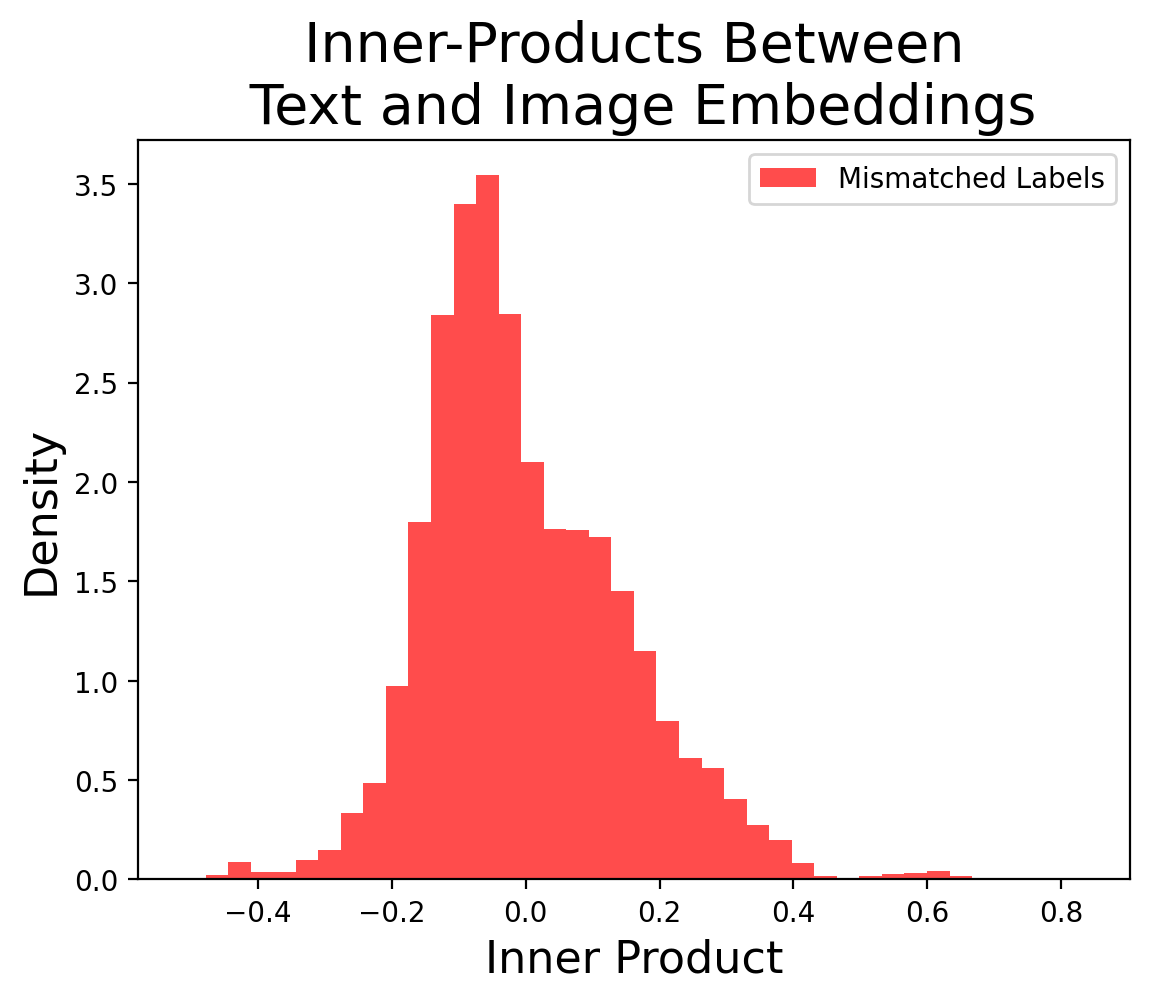

In [ ]:
# Create the density histogram
plt.hist(distances_text - distances_image, bins=40, color='red', alpha=0.7, label='Mismatched Labels', density=True)

# Customize the plot
plt.title('Inner-Products Between\n Text and Image Embeddings', fontsize = 20)
plt.xlabel('Inner Product', fontsize = 16)
plt.ylabel('Density', fontsize = 16)
plt.legend()

# Show the plot
plt.show()